In [1]:
from brian2 import *
from scipy.signal import savgol_filter

# Intro
This notebook demonstrates how to implement an extracellular field in _brian_ (https://briansimulator.org/).
We calculate the impact of an homogenious external field, as well as the impact of the field generated by a current point source.

Please cite as:
> Schlötter Moritz, Maret Georg, Kleineidam Christoph J (2023) Annihilation of action potentials induces electrical coupling between neurons eLife 12:RP88335
>
> https://doi.org/10.7554/eLife.88335

# Morphology and Parameter

In [2]:
# Morphology and Parameter
diameter = 1*um
length = 300*um
N = 201
Cm = 1*uF/cm**2
Ri = 150*ohm*cm

morpho = Cylinder(diameter=diameter, x=[-length/2/um, length/2/um]*um, n=N)

# Calculate external field at each compartment

Text(0, 0.5, 'V/mm^2')

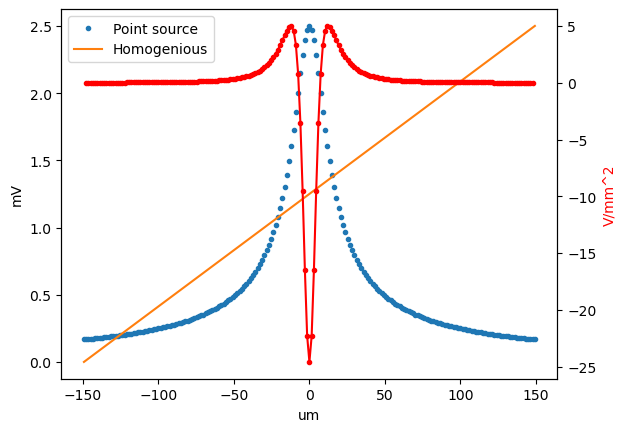

In [3]:
# Point Source
I_ext = 0.01 * uA
rho = 1 / (0.4 * siemens / meter)
dist_y = 10 * um
V_e_pointsource = rho * I_ext / np.sqrt(dist_y**2 + morpho.x**2)
# Homogenious field
V_e_homogenious = np.linspace(0, 2.5, morpho.n) * 1e-3 * volt

# Plot el. Potential
ln = plt.plot(morpho.x / um, V_e_pointsource / mV, ".", label="Point source")
plt.plot(morpho.x / um, V_e_homogenious / mV, label="Homogenious")
plt.ylabel('mV')
plt.xlabel('um')
plt.legend()

# Plot second derivative of el. Potential
plt.twinx()
af = (np.diff(V_e_pointsource, n=2) / (np.diff(morpho.x)[1:])**2)
plt.plot(morpho.x[1:-1] / um, af / (volt / mm**2), ".-", color='red')
plt.ylabel('V/mm^2', color="red")

# Running the Simulation

In [18]:
def runSimulation(V_e,
                  dt=0.01 * ms,
                  method='exponential_euler',
                  duration = 1 * ms,
                  g_L=1e-15 * siemens / cm**2):

    start_scope()
    defaultclock.dt = dt

    # Define neuron
    eqs = '''
        Im = -g_L * v : amp/meter**2
        I : amp (point current)
    '''
    neuron = SpatialNeuron(morphology=morpho,
                           model=eqs,
                           Cm=Cm,
                           Ri=Ri,
                           method=method)
    # Set initial state
    neuron.v = 0*mV
    neuron.I = 0*mA

    # Axial resistance between the compartments
    ri = Ri / (np.pi*(neuron.morphology.diameter/2.0)**2)
    ri_between = (ri[1:] + ri[:-1])/2.0
    # Distances between the compartments
    compartment_distances = np.diff(neuron.x)

    # The effect of the external field is a distributed current injection
    @network_operation()
    def update_extracellular(t):
        # Inner axial electric field
        E_ax = np.diff(V_e, n=1) / compartment_distances
        # Inner axial current
        I_ax = E_ax / ri_between
        # For all inner compartments, the change of inner axial current causes the membrane charging
        dI_ax = np.diff(I_ax, n=1)
        neuron.I[1:-1] = dI_ax
        # At the first and last compartment, the axial current is the membrane current
        neuron.I[0] = I_ax[0]
        neuron.I[-1] = -I_ax[-1]

    M = StateMonitor(neuron, ('v', 'I'), record=True)

    run(duration)  # , report='text')
    return M

## Point source

In [19]:
M = runSimulation(V_e=V_e_pointsource,
                  method="rk4")

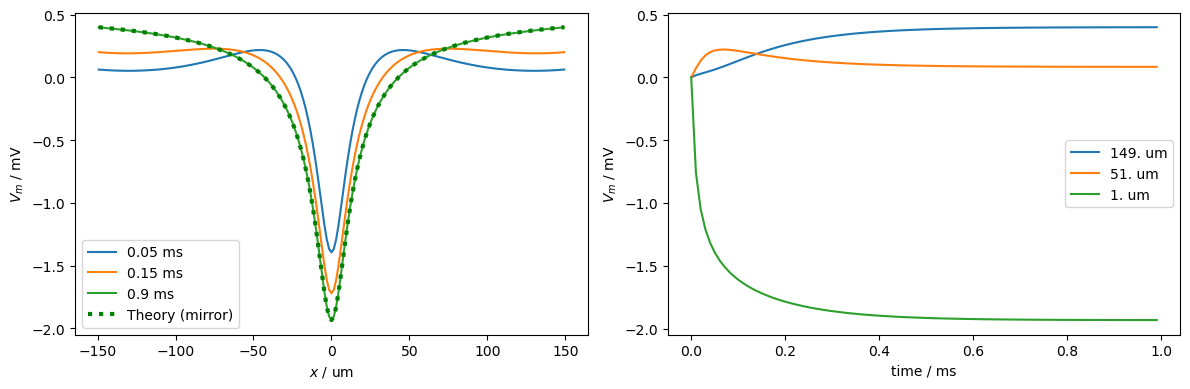

In [20]:
# Make plots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
target_morphology = morpho
m_target_pel = M
potential = V_e_pointsource

def plt_at_t(t):
    i_t = argmin(absolute(M.t-t))
    axs[0].plot(target_morphology.x/um, m_target_pel.v[:,i_t]/mV, label=m_target_pel.t[i_t].in_unit(ms,2))

plt_at_t(0.05*ms)
plt_at_t(0.15*ms)
#plt_at_t(0.4*ms)
plt_at_t(0.9*ms)

mirror = -potential + potential.mean()
axs[0].plot(target_morphology.x/um, mirror/mV, ':', lw=3, color='green', label='Theory (mirror)')
axs[0].set_ylabel('$V_m$ / mV')
axs[0].set_xlabel('$x$ / um')
axs[0].legend()

n_x = target_morphology.n
axs[1].plot(m_target_pel.t/ms, m_target_pel.v[-1,:]/mV, label=target_morphology.x[-1].in_unit(um, 0))
axs[1].plot(m_target_pel.t/ms, m_target_pel.v[-n_x//3,:]/mV, label=target_morphology.x[-n_x//3].in_unit(um, 0))
axs[1].plot(m_target_pel.t/ms, m_target_pel.v[n_x//2,:]/mV, label=target_morphology.x[1+n_x//2].in_unit(um, 0))
axs[1].set_ylabel('$V_m$ / mV')
axs[1].set_xlabel('time / ms')
axs[1].legend()

plt.tight_layout()

## Homogenious field

In [21]:
M = runSimulation(V_e=V_e_homogenious, duration=4*ms)

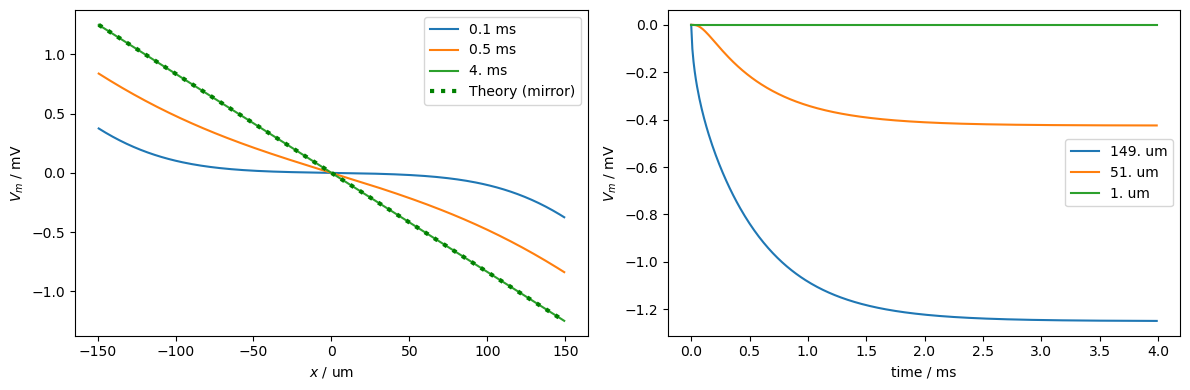

In [24]:
# Make plots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
target_morphology = morpho
m_target_pel = M
potential = V_e_homogenious

def plt_at_t(t):
    i_t = argmin(absolute(M.t-t))
    axs[0].plot(target_morphology.x/um, m_target_pel.v[:,i_t]/mV, label=m_target_pel.t[i_t].in_unit(ms,1))

plt_at_t(0.1*ms)
plt_at_t(0.5*ms)
#plt_at_t(0.4*ms)
plt_at_t(4*ms)

mirror = -potential + potential.mean()
axs[0].plot(target_morphology.x/um, mirror/mV, ':', lw=3, color='green', label='Theory (mirror)')
axs[0].set_ylabel('$V_m$ / mV')
axs[0].set_xlabel('$x$ / um')
axs[0].legend()

n_x = target_morphology.n
axs[1].plot(m_target_pel.t/ms, m_target_pel.v[-1,:]/mV, label=target_morphology.x[-1].in_unit(um, 0))
axs[1].plot(m_target_pel.t/ms, m_target_pel.v[-n_x//3,:]/mV, label=target_morphology.x[-n_x//3].in_unit(um, 0))
axs[1].plot(m_target_pel.t/ms, m_target_pel.v[n_x//2,:]/mV, label=target_morphology.x[1+n_x//2].in_unit(um, 0))
axs[1].set_ylabel('$V_m$ / mV')
axs[1].set_xlabel('time / ms')
axs[1].legend()

plt.tight_layout()